In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.ranker import generate_ranker_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ranker"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ranker']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-04 23:59:53.833082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-04 23:59:53.905063: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-04 23:59:54.354085: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_068


In [2]:
oof = pd.read_csv(f'/kaggle/output/{CFG["2nd_stage"]["execution"]["best_exp_id"]}/oof.csv')
oof = oof.rename(columns={"oof": "oof_stage2"})
sub = pd.read_csv(f'/kaggle/output/{CFG["regressor"]["execution"]["best_exp_id"]}/submission.csv')
sub.drop(columns=["oof_stage2"], inplace=True)
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
display(oof.head())
display(sub.head())
display(labels.head())

,series_id,oof_1st,step,oof_stage2,minutes
0,038441c925bb,0.999923,11.5,0.999923,NaN
1,038441c925bb,0.999829,35.5,0.999829,NaN
2,038441c925bb,0.994979,59.5,0.994979,NaN
3,038441c925bb,0.993882,83.5,0.993882,NaN
4,038441c925bb,0.993127,107.5,0.993127,NaN


,step,sub_step_before_modify,key_step,series_id,score,event,oof_regressor,target,minutes,level
0,4319,4319.0,4331.5,038441c925bb,0.834676,onset,0.349690,0.0,NaN,5.0
1,4772,4679.0,4691.5,038441c925bb,0.834676,onset,93.151360,0.0,NaN,3.0
2,4988,4919.0,4931.5,038441c925bb,0.834676,onset,69.370323,73.0,1257.5,1.0
3,4996,5039.0,5051.5,038441c925bb,0.834676,onset,-42.952278,-47.0,1857.5,0.0
4,5004,5159.0,5171.5,038441c925bb,0.834676,onset,-154.876495,-167.0,2457.5,2.0


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


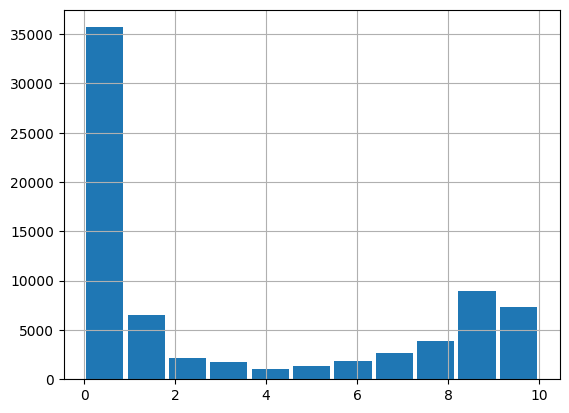

series_id                 5331163
step                      5331163
oof_stage2                5331163
minutes                    877617
target                      73351
sub_step                    73351
key_step                    73351
sub_step_before_modify      73351
event                       73351
level                       73351
score                       73294
oof_regressor               73351
dtype: int64
5.210061650591724


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,sub_step_before_modify,event,level,score,oof_regressor
0,038441c925bb,11.5,0.999923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,038441c925bb,35.5,0.999829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,038441c925bb,59.5,0.994979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,038441c925bb,83.5,0.993882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,038441c925bb,107.5,0.993127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# 正解ラベルを作成
thresholds = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    targets = np.zeros(len(sub_df))
    for thresh in thresholds:
        for step in label_df["step"].values:
            for idx, sub_step in enumerate(sub_df["step"].values):
                dist = abs(step - sub_step)
                if dist < thresh:
                    targets[idx] += 1
    sub_df["target"] = targets
    sub_df["sub_step"] = sub_df["step"].values
    dfs.append(sub_df)
sub = pd.concat(dfs).reset_index(drop=True)
plt.hist(sub["target"].values, bins=11, rwidth=0.9)
plt.grid()
plt.show()

train = oof[["series_id", "step", "oof_stage2", "minutes"]].merge(
    sub[["target", "series_id", 
         "sub_step", "key_step", "sub_step_before_modify",
         "event", "level", "score", "oof_regressor"]], 
    left_on=["series_id", "step"], 
    right_on=["series_id", "key_step"], 
    how="left",
    )
print((~train.isna()).sum())
print((train.target ** 2).mean() ** 0.5)
display(train.head())

In [4]:
# スコアの理論値(targetを完璧に当てれた場合)
ideal_sub = sub.copy()
ideal_sub["score"] = ideal_sub["target"]
ideal_sub["step"] = ideal_sub["sub_step"]

labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, ideal_sub)
print(f"score: {score:.4f}")
display(ap_table)

score: 0.4475


event   tolerance
onset   12           0.288004
        36           0.390757
        60           0.430391
        90           0.451663
        120          0.464943
        150          0.471660
        180          0.475959
        240          0.477678
        300          0.479266
        360          0.480822
wakeup  12           0.302495
        36           0.398899
        60           0.438248
        90           0.462764
        120          0.478053
        150          0.486818
        180          0.490887
        240          0.492276
        300          0.493995
        360          0.495111
dtype: float64

In [5]:
# 再現率
thresholds = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    for thresh in thresholds:
        targets = np.zeros(len(label_df))
        for idx, step in enumerate(label_df["step"].values):           
            min_dist = thresh
            min_idx = -1            
            for sub_step in sub_df["step"].values:    
                dist = abs(step - sub_step)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = idx
            if min_idx != -1:
                targets[idx] = True
        label_df["target"] = targets
        label_df["threshold"] = thresh
        dfs.append(label_df.copy())
recall_df = pd.concat(dfs).reset_index(drop=True)
print(recall_df["target"].mean())
display(recall_df.groupby(["event", "threshold"])["target"].mean())

0.8643505477308294


event   threshold
onset   12           0.468169
        36           0.717178
        60           0.821749
        90           0.882071
        120          0.920267
        150          0.941975
        180          0.953872
        240          0.958255
        300          0.961177
        360          0.966187
wakeup  12           0.486233
        36           0.716938
        60           0.819983
        90           0.889237
        120          0.932833
        150          0.958281
        180          0.969962
        240          0.972048
        300          0.974552
        360          0.976012
Name: target, dtype: float64

In [6]:
# 特徴生成
train, features = generate_ranker_features(train)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

100%|██████████| 277/277 [03:24<00:00,  1.36it/s]


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,sub_step_before_modify,event,level,...,for_pred_rolling_min_50_shift_100_diff,oof_stage2_rolling_median_50_shift_100_diff,oof_stage2_diff_abs_rolling_median_50_shift_100_diff,oof_stage2_mean_rolling_median_50_shift_100_diff,for_pred_rolling_median_50_shift_100_diff,oof_stage2_rolling_square_mean_50_shift_100_diff,oof_stage2_diff_abs_rolling_square_mean_50_shift_100_diff,oof_stage2_mean_rolling_square_mean_50_shift_100_diff,for_pred_rolling_square_mean_50_shift_100_diff,fold
0,038441c925bb,4331.5,0.999193,NaN,0.0,4319.0,4331.5,4319.0,onset,5.0,...,0.0,0.960272,-0.002529,0.737917,0.0,0.998246,-0.000057,0.927509,0.0,2
1,038441c925bb,4691.5,0.998122,NaN,3.0,4772.0,4691.5,4679.0,onset,3.0,...,0.0,0.959926,-0.003268,0.719422,0.0,0.998064,-0.000062,0.921510,0.0,2
2,038441c925bb,4931.5,0.978979,1257.5,10.0,4988.0,4931.5,4919.0,onset,1.0,...,0.0,0.956779,-0.003403,0.711094,0.0,0.997368,-0.000110,0.908672,0.0,2
3,038441c925bb,5051.5,0.120360,1857.5,10.0,4996.0,5051.5,5039.0,onset,0.0,...,0.0,0.955621,-0.004250,0.706929,0.0,0.996829,-0.000130,0.899326,0.0,2
4,038441c925bb,5171.5,0.151996,2457.5,9.0,5004.0,5171.5,5159.0,onset,2.0,...,0.0,0.955607,-0.003614,0.704544,0.0,0.995787,-0.000106,0.888587,0.0,2


(73351, 1390)

In [7]:
# 学習
trn_oof, models = fit_xgb(
    X=train, 
    y=train["target"], 
    folds=train["fold"].astype(int), 
    features=features.all_features(),
    params=CFG["ranker"]["xgboost"], 
    es_rounds=100,
)
train["oof_ranker"] = trn_oof
train["score"] = train["oof_ranker"]
train["key_step"] = train["step"]
train["step"] = train["sub_step"].astype(int)
sub = train[["score", "key_step", "step", "event", "level", "series_id"]]

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))
with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:4.92883
[100]	eval-rmse:2.58012
[200]	eval-rmse:2.05137
[300]	eval-rmse:1.96369
[400]	eval-rmse:1.94940
[500]	eval-rmse:1.94665
[600]	eval-rmse:1.94597
[700]	eval-rmse:1.94598
[708]	eval-rmse:1.94603


 20%|██        | 1/5 [00:15<01:00, 15.12s/it]

== fold 1 ==
[0]	eval-rmse:4.90860
[100]	eval-rmse:2.58610
[200]	eval-rmse:2.03165
[300]	eval-rmse:1.92247
[400]	eval-rmse:1.89978
[500]	eval-rmse:1.89239
[600]	eval-rmse:1.88903
[700]	eval-rmse:1.88730
[800]	eval-rmse:1.88645
[900]	eval-rmse:1.88588
[1000]	eval-rmse:1.88581
[1026]	eval-rmse:1.88602


 40%|████      | 2/5 [00:34<00:53, 17.90s/it]

== fold 2 ==
[0]	eval-rmse:4.82462
[100]	eval-rmse:2.54666
[200]	eval-rmse:2.03140
[300]	eval-rmse:1.93858
[400]	eval-rmse:1.91985
[500]	eval-rmse:1.91442
[600]	eval-rmse:1.91338
[700]	eval-rmse:1.91253
[800]	eval-rmse:1.91170
[900]	eval-rmse:1.91177
[1000]	eval-rmse:1.91167
[1024]	eval-rmse:1.91174


 60%|██████    | 3/5 [00:54<00:37, 18.54s/it]

== fold 3 ==
[0]	eval-rmse:4.87940
[100]	eval-rmse:2.57292
[200]	eval-rmse:2.07026
[300]	eval-rmse:1.99794
[400]	eval-rmse:1.99270
[451]	eval-rmse:1.99271


 80%|████████  | 4/5 [01:04<00:15, 15.25s/it]

== fold 4 ==
[0]	eval-rmse:4.80232
[100]	eval-rmse:2.54466
[200]	eval-rmse:2.08615
[300]	eval-rmse:2.02744
[400]	eval-rmse:2.02385
[464]	eval-rmse:2.02444


100%|██████████| 5/5 [01:14<00:00, 14.91s/it]


In [8]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)

score: 0.3248


event   tolerance
onset   12           0.123271
        36           0.261035
        60           0.308332
        90           0.334322
        120          0.350608
        150          0.360200
        180          0.365202
        240          0.369515
        300          0.372898
        360          0.375879
wakeup  12           0.141259
        36           0.261856
        60           0.309647
        90           0.337256
        120          0.353883
        150          0.364786
        180          0.370370
        240          0.375036
        300          0.379199
        360          0.381471
dtype: float64